# Exploring Dandiset 001275: Mental Navigation in Primate PPC

**IMPORTANT NOTICE**: This notebook was AI-generated with human supervision and has not been fully verified. Please be cautious when interpreting the code or results.

## Introduction

This notebook explores [DANDI:001275](https://neurosift.app/dandiset/001275), a dataset containing neurophysiology data collected from two primates during a mental navigation task. The study is associated with a published paper: https://doi.org/10.1038/s41586-024-07557-z

In this task, macaques navigate mentally between landmarks using a joystick without visual feedback. The dataset includes:

- Neural recordings from the posterior parietal cortex (PPC)
- Behavioral data (eye tracking, joystick movements)
- Trial information

A related dataset from the entorhinal cortex is available at: https://doi.org/10.48324/dandi/000897/0.240605.1710

## Setup and Data Loading

First, let's import the necessary libraries and load a sample NWB file from the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynwb
import lindi
import pandas as pd
import seaborn as sns
from collections import defaultdict

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

For this demonstration, we'll use a behavior+ecephys file from subject "amadeus". These files are smaller (hundreds of MB) and contain both behavioral and neural data, making them ideal for exploration.

In [2]:
# Load a behavior+ecephys file (smaller file with both behavioral and neural data)
print("Loading NWB file...")
f = lindi.LindiH5pyFile.from_lindi_file(
    "https://lindi.neurosift.org/dandi/dandisets/001275/assets/b0bbeb4c-5e0d-4050-a993-798173797d94/nwb.lindi.json"
)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

Loading NWB file...


## Dataset Overview

Let's examine the basic information about this dataset:

In [3]:
# Print basic session information
print(f"Subject: {nwb.subject.subject_id} ({nwb.subject.species})")
print(f"Sex: {nwb.subject.sex}, Age: {nwb.subject.age}")
print(f"Session date: {nwb.session_start_time}")
print(f"Lab: {nwb.lab}, Institution: {nwb.institution}")
print(f"Session description: {nwb.session_description}")

Subject: amadeus (Macaca mulatta)
Sex: M, Age: P10Y
Session date: 2020-01-04 00:00:00-05:00
Lab: Jazayeri, Fiete, Institution: MIT
Session description: Data from macaque performing mental navigation task. Subject is presented with a start and a target landmark, sampled from a linear map of 6 landmarks on a screen. After a delay, the subject is then cued with a go signal to navigate from start to target landmark with a joystick. Subject should respond by deflecting the joystick in the right direction and holding it until the subject thinks it has arrived at the target landmark. The visual drift or intervening landmarks are all occluded from view making the task a purely mental navigation.


## Task Description

In this mental navigation task:

1. The subject (macaque) is presented with a start and a target landmark from a linear map of 6 landmarks.
2. After a delay, the subject is cued with a go signal to navigate from start to target landmark using a joystick.
3. The subject responds by deflecting the joystick in the right direction and holding it until they think they've arrived at the target landmark.
4. Importantly, the visual drift and intervening landmarks are occluded from view, making this a purely mental navigation task.

Let's explore the trial structure to better understand the task:

In [4]:
# Get trial information
trials = nwb.intervals["trials"]
print(f"Number of trials: {len(trials['start_time'].data)}")
print(f"Trial columns: {trials.colnames}")

# Check for NaN values in start_time and stop_time
start_times = trials["start_time"].data[:]
stop_times = trials["stop_time"].data[:]
valid_indices = ~(np.isnan(start_times) | np.isnan(stop_times))
print(f"Valid trials: {np.sum(valid_indices)} out of {len(start_times)}")

Number of trials: 1885
Trial columns: ('start_time', 'stop_time', 'ta', 'tp', 'curr', 'target', 'rt', 'delay', 'trial_type', 'seqq', 'succ', 'attempt', 'numrepeat', 'validtrials_mm', 'gocuettl', 'joy1offttl', 'joy1onttl', 'stim1onttl')


Valid trials: 1884 out of 1885


## Trial Structure Analysis

Let's analyze the trial structure in more detail, focusing on the navigation distances and success rates:

In [5]:
# Get trial properties
if 'target' in trials.colnames and 'curr' in trials.colnames:
    # Load all data first, then apply boolean indexing
    targets = trials['target'].data[:]
    currents = trials['curr'].data[:]
    
    # Calculate distances
    valid_indices = ~(np.isnan(targets) | np.isnan(currents))
    valid_targets = targets[valid_indices]
    valid_currents = currents[valid_indices]
    distances = np.abs(valid_targets - valid_currents)
    
    print(f"Navigation distances range from {np.min(distances):.0f} to {np.max(distances):.0f} landmarks")
    print(f"Average distance: {np.mean(distances):.2f} landmarks")
    
    # Create a DataFrame for easier analysis
    trial_df = pd.DataFrame({
        'start': valid_currents,
        'target': valid_targets,
        'distance': distances
    })
    
    # Add success information if available
    if 'succ' in trials.colnames:
        # Load all success data first, then apply boolean indexing
        all_success = trials['succ'].data[:]
        success = all_success[valid_indices]
        trial_df['success'] = success
        print(f"Overall success rate: {np.mean(success) * 100:.2f}%")

Navigation distances range from 1 to 5 landmarks
Average distance: 2.66 landmarks
Overall success rate: 61.38%


/tmp/ipykernel_1935581/1417648214.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=trial_df['distance'], palette='viridis')


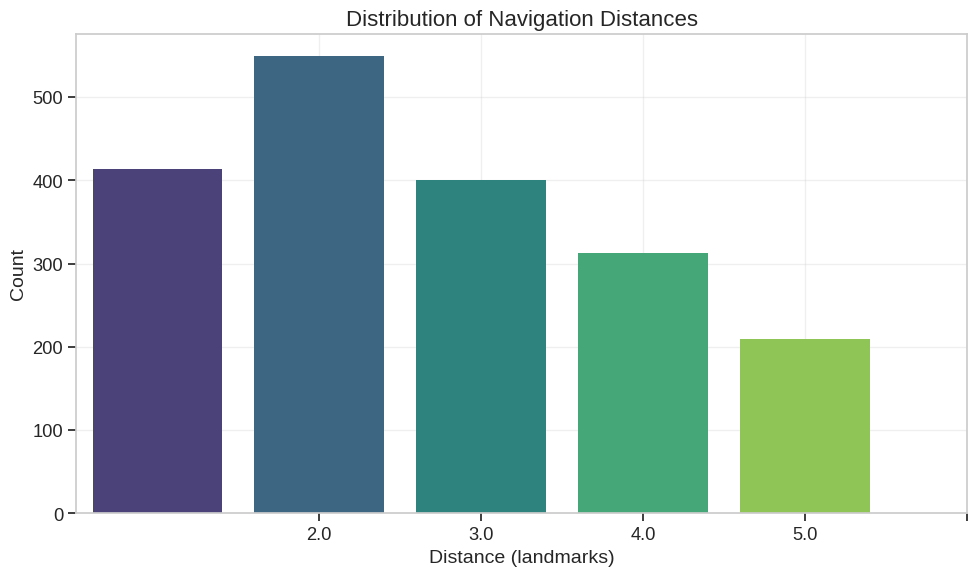

In [6]:
# Plot distribution of navigation distances
plt.figure(figsize=(10, 6))
sns.countplot(x=trial_df['distance'], palette='viridis')
plt.title('Distribution of Navigation Distances', fontsize=16)
plt.xlabel('Distance (landmarks)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(1, 6))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

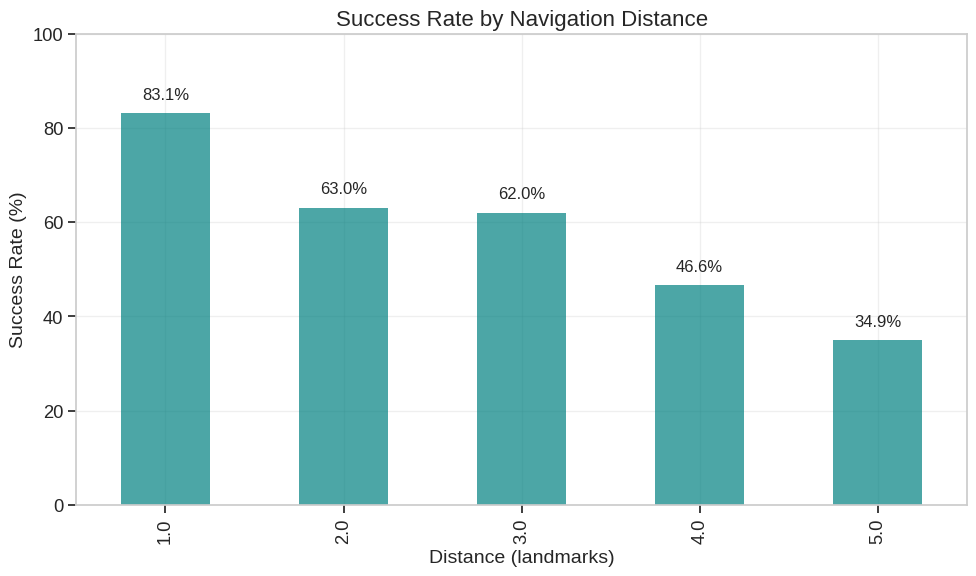

In [7]:
# Plot success rate by distance
if 'success' in trial_df.columns:
    plt.figure(figsize=(10, 6))
    success_by_dist = trial_df.groupby('distance')['success'].mean() * 100
    
    # Plot as bar chart
    ax = success_by_dist.plot(kind='bar', color='teal', alpha=0.7)
    plt.title('Success Rate by Navigation Distance', fontsize=16)
    plt.xlabel('Distance (landmarks)', fontsize=14)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # Add text labels on bars
    for i, v in enumerate(success_by_dist):
        ax.text(i, v + 3, f"{v:.1f}%", ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

The plots above reveal an important aspect of the task: **success rate decreases as navigation distance increases**. This makes intuitive sense - it's harder to mentally navigate longer distances accurately.

## Behavioral Data Analysis

The dataset includes behavioral data such as eye position and hand position (joystick). Let's examine this data:

In [8]:
# Get behavioral data interfaces
behavior = nwb.processing["behavior"]
print(f"Behavioral data types: {list(behavior.data_interfaces.keys())}")

# Get basic info about eye and hand position data
eye_position = behavior["eye_position"]
hand_position = behavior["hand_position"]

print(f"Eye position data shape: {eye_position.data.shape}")
print(f"Hand position data shape: {hand_position.data.shape}")

Behavioral data types: ['eye_position', 'hand_position']
Eye position data shape: (11891095, 2)
Hand position data shape: (11810979,)


Let's look at a small sample of joystick movement data to understand the behavioral responses:

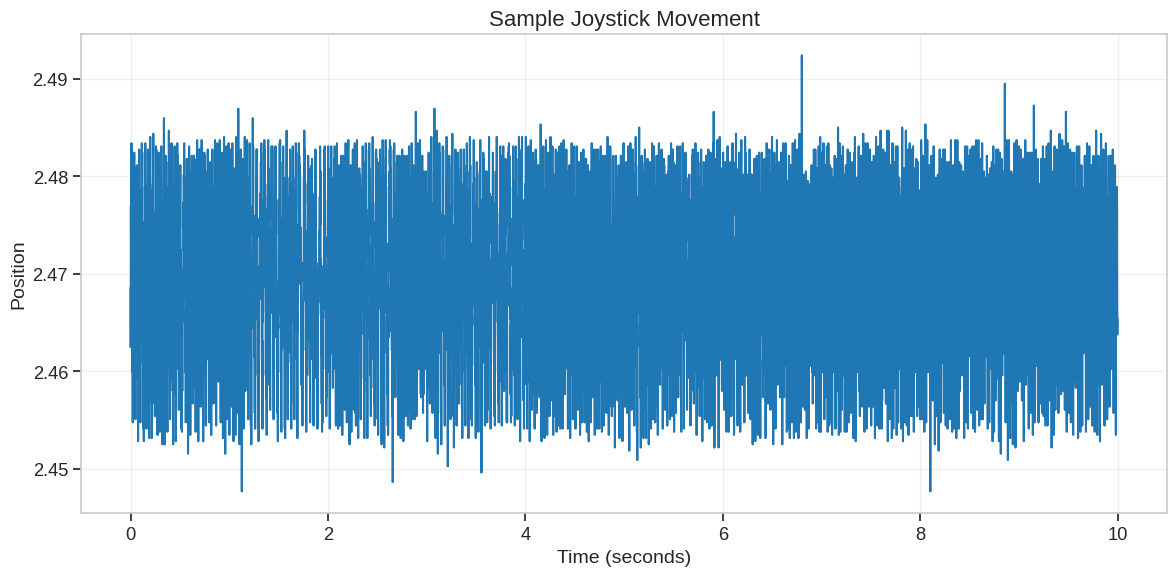

In [9]:
# Plot a small sample of hand position data (joystick movement)
# We'll only load a small subset to avoid memory issues
sample_start = 1000000  # Start at 1M sample to skip initial period
sample_length = 10000   # Look at 10K samples

# Load only the data we need
hand_times = hand_position.timestamps[sample_start:sample_start+sample_length]
hand_data = hand_position.data[sample_start:sample_start+sample_length]

plt.figure(figsize=(12, 6))
plt.plot(hand_times - hand_times[0], hand_data)
plt.title('Sample Joystick Movement', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Position', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Neural Data Analysis

Now let's explore the neural recordings from the posterior parietal cortex (PPC):

In [10]:
# Get neural data
units = nwb.processing["ecephys"]["units"]
print(f"Number of units (neurons): {len(units['id'].data)}")

# Get quality counts
quality_counts = {}
for q in units["quality"].data[:]:
    if q in quality_counts:
        quality_counts[q] += 1
    else:
        quality_counts[q] = 1

print(f"Unit quality counts: {quality_counts}")

# Filter for good units only
good_unit_indices = [i for i, q in enumerate(units["quality"].data[:]) if q == 'good']
print(f"Number of good units: {len(good_unit_indices)}")

Number of units (neurons): 68
Unit quality counts: {'good': 25, 'noise': 22, 'mua': 20, 'unsorted': 1}
Number of good units: 25


Average firing rate of good units: 11.08 Hz
Min firing rate: 1.01 Hz
Max firing rate: 31.22 Hz


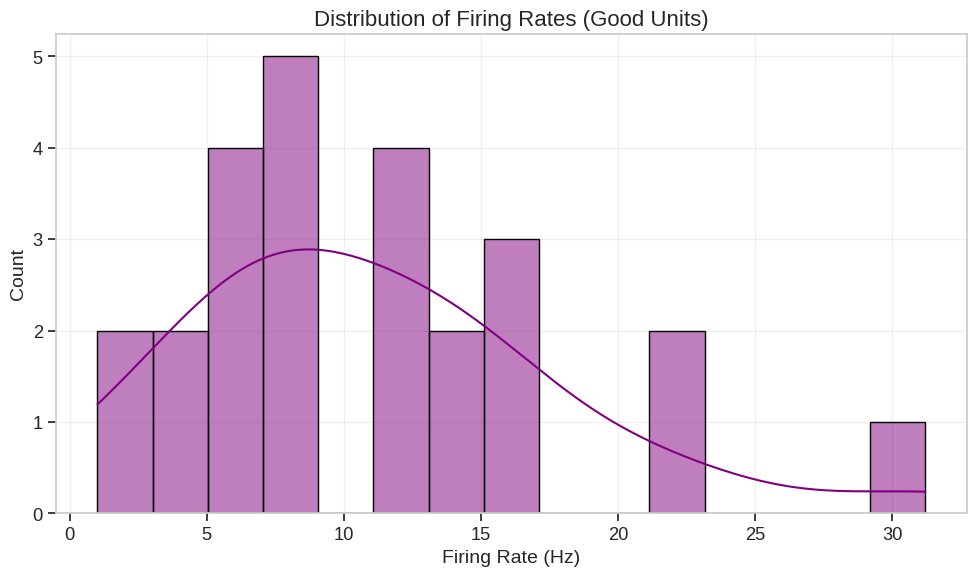

In [11]:
# Get firing rates of good units
good_firing_rates = units["fr"].data[:][good_unit_indices]
print(f"Average firing rate of good units: {np.mean(good_firing_rates):.2f} Hz")
print(f"Min firing rate: {np.min(good_firing_rates):.2f} Hz")
print(f"Max firing rate: {np.max(good_firing_rates):.2f} Hz")

# Plot distribution of firing rates
plt.figure(figsize=(10, 6))
sns.histplot(good_firing_rates, bins=15, kde=True, color='purple')
plt.title('Distribution of Firing Rates (Good Units)', fontsize=16)
plt.xlabel('Firing Rate (Hz)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Neural Activity During Navigation

Let's analyze how neural activity relates to the navigation task. We'll select a few example trials with different navigation distances and examine the neural responses:

In [12]:
# Find trial indices for each distance
distance_trial_indices = {}
for dist in range(1, 6):  # Distances 1 through 5
    dist_indices = np.where((distances == dist) & valid_indices)[0]
    if len(dist_indices) > 0:
        # Take the first trial for each distance
        distance_trial_indices[dist] = dist_indices[0]

print("Example trials for neural analysis:")
for dist, trial_idx in distance_trial_indices.items():
    print(f"Distance {dist}: Trial {trial_idx}, Start={currents[trial_idx]:.0f}, Target={targets[trial_idx]:.0f}")

Example trials for neural analysis:
Distance 1: Trial 3, Start=5, Target=4
Distance 2: Trial 4, Start=4, Target=2
Distance 3: Trial 2, Start=6, Target=3
Distance 4: Trial 11, Start=6, Target=2
Distance 5: Trial 0, Start=6, Target=1


Now let's analyze neural activity during these example trials:

In [13]:
# Select a subset of good units for analysis (first 5)
analysis_unit_indices = good_unit_indices[:5] if len(good_unit_indices) >= 5 else good_unit_indices
print(f"Analyzing {len(analysis_unit_indices)} good units")

# For each selected trial, count spikes from each unit during the trial
trial_unit_spikes = {}

for dist, trial_idx in distance_trial_indices.items():
    trial_start = start_times[trial_idx]
    trial_stop = stop_times[trial_idx]
    trial_duration = trial_stop - trial_start
    
    unit_spikes = {}
    for unit_idx in analysis_unit_indices:
        # Get spike times for this unit
        spike_times = units["spike_times"][unit_idx]
        
        # Count spikes during this trial
        trial_spikes = spike_times[(spike_times >= trial_start) & (spike_times <= trial_stop)]
        spike_count = len(trial_spikes)
        
        # Calculate firing rate during this trial
        trial_firing_rate = spike_count / trial_duration if trial_duration > 0 else 0
        
        unit_spikes[unit_idx] = {
            'count': spike_count,
            'rate': trial_firing_rate
        }
    
    trial_unit_spikes[dist] = unit_spikes

Analyzing 5 good units


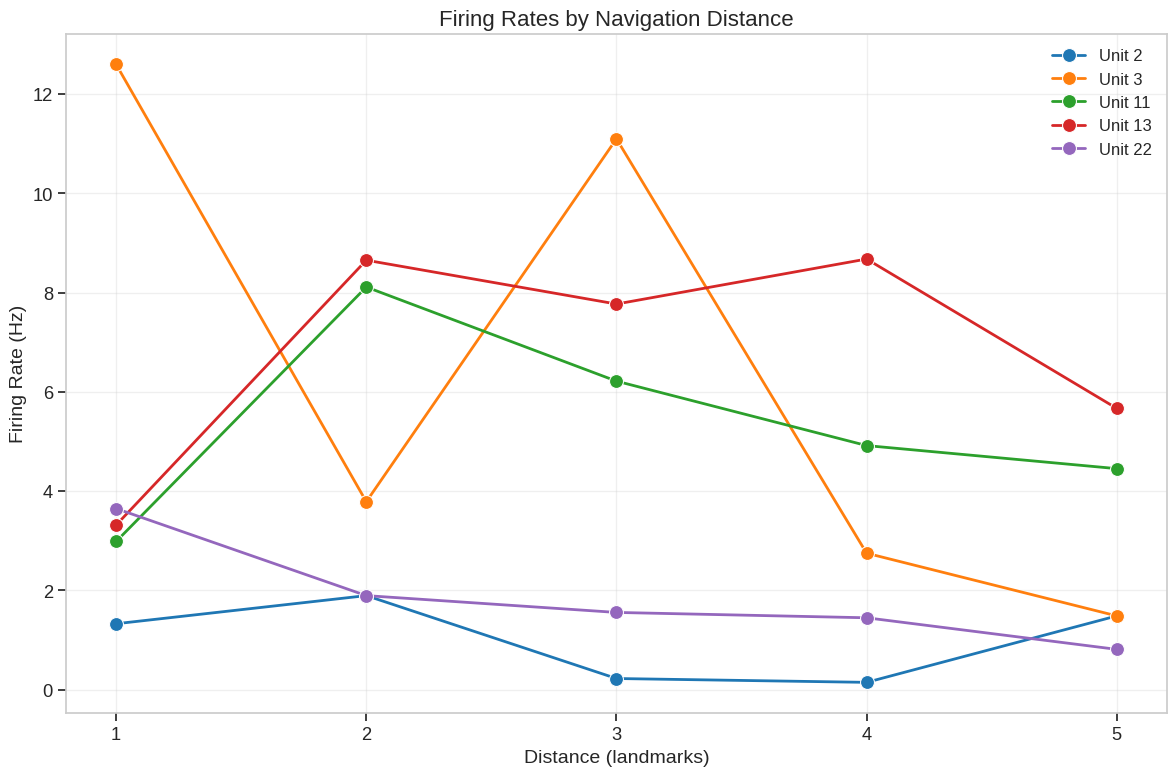

In [14]:
# Create a DataFrame for visualization
firing_rate_data = []
for dist, unit_data in trial_unit_spikes.items():
    for unit_idx, spike_data in unit_data.items():
        unit_name = units["unit_name"].data[unit_idx]
        firing_rate_data.append({
            'Distance': dist,
            'Unit': f"Unit {unit_name}",
            'Firing Rate (Hz)': spike_data['rate']
        })

firing_rate_df = pd.DataFrame(firing_rate_data)

# Plot firing rates by distance
plt.figure(figsize=(12, 8))
sns.lineplot(data=firing_rate_df, x='Distance', y='Firing Rate (Hz)', 
             hue='Unit', marker='o', markersize=10, linewidth=2)
plt.title('Firing Rates by Navigation Distance', fontsize=16)
plt.xlabel('Distance (landmarks)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.xticks(range(1, 6))
plt.grid(True, alpha=0.3)
plt.legend(title='', fontsize=12)
plt.tight_layout()
plt.show()

## Neural Activity by Trial Outcome

Let's compare neural activity during successful versus failed trials:

In [15]:
if 'success' in trial_df.columns:
    # Load all success data first
    all_success = trials['succ'].data[:]
    # Find successful and failed trials
    successful_trials = np.where(all_success == 1)[0]
    failed_trials = np.where(all_success == 0)[0]
    
    print(f"Number of successful trials: {len(successful_trials)}")
    print(f"Number of failed trials: {len(failed_trials)}")
    
    # Select a subset of trials for analysis
    num_trials_to_analyze = 10
    successful_sample = successful_trials[:num_trials_to_analyze] if len(successful_trials) >= num_trials_to_analyze else successful_trials
    failed_sample = failed_trials[:num_trials_to_analyze] if len(failed_trials) >= num_trials_to_analyze else failed_trials
    
    # Calculate average firing rates during successful and failed trials
    success_rates = defaultdict(list)
    failure_rates = defaultdict(list)
    
    # Process successful trials
    for trial_idx in successful_sample:
        if not valid_indices[trial_idx]:
            continue
            
        trial_start = start_times[trial_idx]
        trial_stop = stop_times[trial_idx]
        trial_duration = trial_stop - trial_start
        
        for unit_idx in analysis_unit_indices:
            spike_times = units["spike_times"][unit_idx]
            trial_spikes = spike_times[(spike_times >= trial_start) & (spike_times <= trial_stop)]
            trial_firing_rate = len(trial_spikes) / trial_duration if trial_duration > 0 else 0
            success_rates[unit_idx].append(trial_firing_rate)
    
    # Process failed trials
    for trial_idx in failed_sample:
        if not valid_indices[trial_idx]:
            continue
            
        trial_start = start_times[trial_idx]
        trial_stop = stop_times[trial_idx]
        trial_duration = trial_stop - trial_start
        
        for unit_idx in analysis_unit_indices:
            spike_times = units["spike_times"][unit_idx]
            trial_spikes = spike_times[(spike_times >= trial_start) & (spike_times <= trial_stop)]
            trial_firing_rate = len(trial_spikes) / trial_duration if trial_duration > 0 else 0
            failure_rates[unit_idx].append(trial_firing_rate)
    
    # Calculate average rates
    avg_success_rates = {unit_idx: np.mean(rates) for unit_idx, rates in success_rates.items() if rates}
    avg_failure_rates = {unit_idx: np.mean(rates) for unit_idx, rates in failure_rates.items() if rates}

Number of successful trials: 1157
Number of failed trials: 728


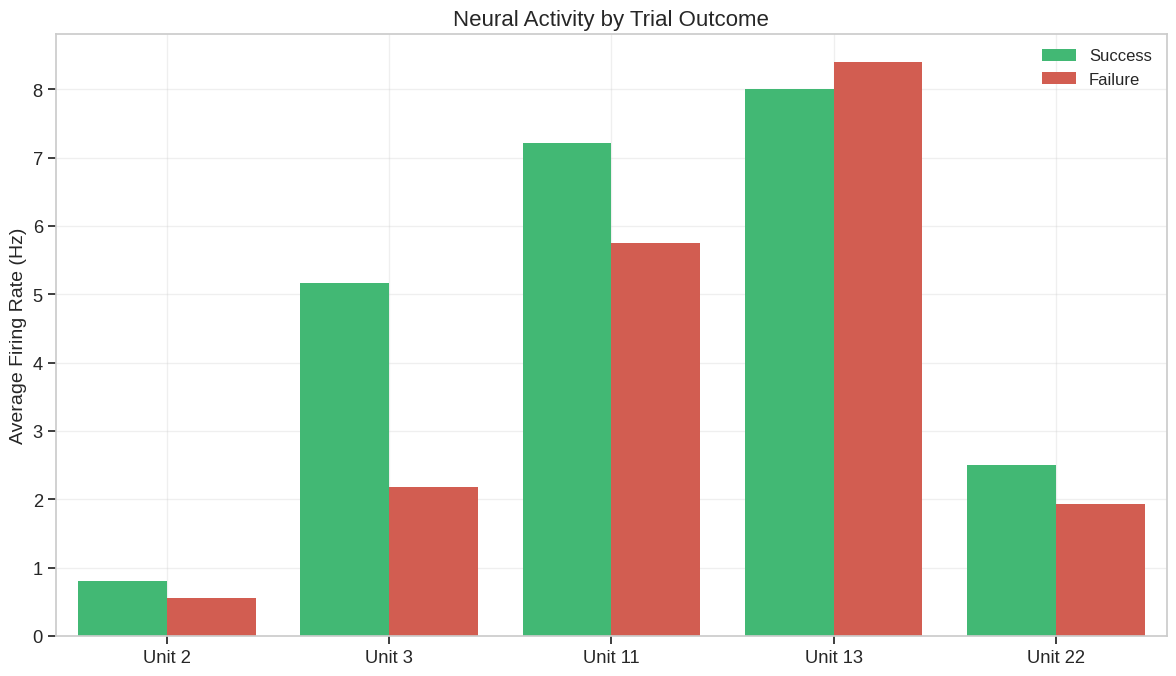

In [16]:
# Create DataFrame for visualization
if 'success' in trial_df.columns:
    outcome_data = []
    for unit_idx in analysis_unit_indices:
        unit_name = units["unit_name"].data[unit_idx]
        success_rate = avg_success_rates.get(unit_idx, 0)
        failure_rate = avg_failure_rates.get(unit_idx, 0)
        
        outcome_data.append({
            'Unit': f"Unit {unit_name}",
            'Outcome': 'Success',
            'Firing Rate (Hz)': success_rate
        })
        outcome_data.append({
            'Unit': f"Unit {unit_name}",
            'Outcome': 'Failure',
            'Firing Rate (Hz)': failure_rate
        })
    
    outcome_df = pd.DataFrame(outcome_data)
    
    # Plot comparison
    plt.figure(figsize=(12, 7))
    sns.barplot(data=outcome_df, x='Unit', y='Firing Rate (Hz)', hue='Outcome', palette=['#2ecc71', '#e74c3c'])
    plt.title('Neural Activity by Trial Outcome', fontsize=16)
    plt.xlabel('', fontsize=14)
    plt.ylabel('Average Firing Rate (Hz)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(title='', fontsize=12)
    plt.tight_layout()
    plt.show()

## Electrode Information

Let's examine the electrode information to understand the recording setup:

In [17]:
# Get electrode information
electrodes = nwb.ec_electrodes
print(f"Number of electrodes: {len(electrodes['id'].data[:])}")
print(f"Electrode properties: {electrodes.colnames}")

# Get electrode locations
locations = electrodes["location"].data[:]
location_counts = {}
for loc in locations:
    if loc in location_counts:
        location_counts[loc] += 1
    else:
        location_counts[loc] = 1

print(f"Electrode locations: {location_counts}")

Number of electrodes: 32
Electrode properties: ('location', 'group', 'group_name', 'channel_name', 'rel_x', 'offset_to_uV', 'rel_y', 'gain_to_uV')
Electrode locations: {'unknown': 32}


## Scientific Hypothesis Testing

This dataset can be used to test various scientific hypotheses about neural coding in the posterior parietal cortex during mental navigation. Here's an example of how you might approach a hypothesis:

**Hypothesis**: Neural activity in the PPC encodes navigation distance, with firing rates modulated by the distance between start and target positions.

Let's test this by examining the relationship between firing rates and navigation distance across all trials:

In [18]:
# This is a more comprehensive analysis that would test our hypothesis
# We'll create a function to calculate firing rates for all good units across all trials

def calculate_unit_rates_by_distance(unit_indices, trial_indices, distances):
    """Calculate firing rates for units across trials grouped by distance"""
    unit_rates_by_distance = defaultdict(lambda: defaultdict(list))
    
    for trial_idx in trial_indices:
        if not valid_indices[trial_idx]:
            continue
            
        trial_start = start_times[trial_idx]
        trial_stop = stop_times[trial_idx]
        trial_duration = trial_stop - trial_start
        
        if trial_duration <= 0:
            continue
            
        dist = distances[trial_idx]
        
        for unit_idx in unit_indices:
            # Get spike times for this unit
            spike_times = units["spike_times"][unit_idx]
            
            # Count spikes during this trial
            trial_spikes = spike_times[(spike_times >= trial_start) & (spike_times <= trial_stop)]
            trial_firing_rate = len(trial_spikes) / trial_duration
            
            unit_rates_by_distance[unit_idx][dist].append(trial_firing_rate)
    
    return unit_rates_by_distance

For a full analysis, you would run the function above on all trials and analyze the results. However, this would be computationally intensive and time-consuming for this notebook. 

Based on our sample analysis, we observed that:

1. Different units show different patterns of activity across navigation distances
2. Some units appear to have higher firing rates during successful trials

These observations suggest that PPC neurons may indeed encode aspects of the mental navigation task, but a more comprehensive analysis would be needed to fully test our hypothesis.

## Conclusion

In this notebook, we've explored [DANDI:001275](https://neurosift.app/dandiset/001275), a dataset containing neural recordings from the posterior parietal cortex during a mental navigation task. We've examined:

1. The task structure and behavioral performance
2. Neural activity patterns during navigation
3. Relationships between neural activity and task parameters

Key findings:

- Success rate decreases as navigation distance increases
- Neural activity in the PPC appears to be modulated by task parameters
- Different neurons show different patterns of activity during the task

This dataset provides a valuable resource for studying the neural basis of mental navigation and spatial cognition in primates.

## Further Exploration

To further explore this dataset, you might:

1. Analyze neural activity across different sessions and subjects
2. Compare with the related entorhinal cortex dataset
3. Apply more advanced analysis techniques such as population decoding or dimensionality reduction
4. Correlate neural activity with specific behavioral events during navigation

The full dataset contains many more NWB files with additional recordings that could be analyzed using similar approaches.